## 超像素图的可视化

### 超像素提取方法来自：
https://github.com/bknyaz/graph_attention_pool

In [1]:
import random
from torchvision import transforms, datasets

import os
import pickle
from scipy.spatial.distance import cdist
from scipy import ndimage
import numpy as np

import dgl
import torch
import time
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

In [2]:
import os
os.chdir('../') # 当前项目的根目录
print(os.getcwd())

/data/benchmarking-gnns


### 相关函数实现

In [3]:
def sigma(dists, kth=8):
    # Get k-nearest neighbors for each node
    knns = np.partition(dists, kth, axis=-1)[:, kth::-1]

    # Compute sigma and reshape
    sigma = knns.sum(axis=1).reshape((knns.shape[0], 1))/kth
    return sigma + 1e-8 # adding epsilon to avoid zero value of sigma

def compute_adjacency_matrix_images(coord, feat, use_feat=False, kth=8):
    coord = coord.reshape(-1, 2)
    # Compute coordinate distance
    c_dist = cdist(coord, coord)
    
    if use_feat:
        # Compute feature distance
        f_dist = cdist(feat, feat)
        # Compute adjacency
        A = np.exp(- (c_dist/sigma(c_dist))**2 - (f_dist/sigma(f_dist))**2 )
    else:
        A = np.exp(- (c_dist/sigma(c_dist))**2)
        
    # Convert to symmetric matrix
    A = 0.5 * (A + A.T)
    #A = 0.5 * A * A.T
    A[np.diag_indices_from(A)] = 0
    return A

def compute_edges_list(A, kth=8+1):
    # Get k-similar neighbor indices for each node
    if 1==1:   
        num_nodes = A.shape[0]
        new_kth = num_nodes - kth
        knns = np.argpartition(A, new_kth-1, axis=-1)[:, new_kth:-1]
        knns_d = np.partition(A, new_kth-1, axis=-1)[:, new_kth:-1]
    else:
        knns = np.argpartition(A, kth, axis=-1)[:, kth::-1]
        knns_d = np.partition(A, kth, axis=-1)[:, kth::-1]
    return knns, knns_d

### 新冠肺炎CT数据集转化为超像素后的class

In [4]:
class COVIDSuperPix(torch.utils.data.Dataset):
    def __init__(self,
                 data_dir,
                 split,
                 use_mean_px=True,
                 use_coord=True,
                 use_feat_for_graph_construct=False,):

        self.split = split
        self.is_test = split.lower() in ['test', 'val']
        with open(os.path.join(data_dir, 'covid19_150sp_%s.pkl' % split), 'rb') as f:
            self.labels, self.sp_data = pickle.load(f)

        self.use_mean_px = use_mean_px
        self.use_feat_for_graph = use_feat_for_graph_construct
        self.use_coord = use_coord
        self.n_samples = len(self.labels)
        self.img_size = 28

    def precompute_graph_images(self):
        print('precompute all data for the %s set...' % self.split.upper())
        self.Adj_matrices, self.node_features, self.edges_lists = [], [], []
        for index, sample in enumerate(self.sp_data):
            mean_px, coord = sample[:2]
            coord = coord / self.img_size
            A = compute_adjacency_matrix_images(coord, mean_px, use_feat=self.use_feat_for_graph)
            edges_list, _ = compute_edges_list(A)
            N_nodes = A.shape[0]
            
            x = None
            if self.use_mean_px:
                x = mean_px.reshape(N_nodes, -1)
            if self.use_coord:
                coord = coord.reshape(N_nodes, 2)
                if self.use_mean_px:
                    x = np.concatenate((x, coord), axis=1)
                else:
                    x = coord
            if x is None:
                x = np.ones(N_nodes, 1)  # dummy features
            
            self.node_features.append(x)
            self.Adj_matrices.append(A)
            self.edges_lists.append(edges_list)

    def __len__(self):
        return self.n_samples

    def __getitem__(self, index):
        g = dgl.DGLGraph()
        g.add_nodes(self.node_features[index].shape[0])
        g.ndata['feat'] = torch.Tensor(self.node_features[index])
        for src, dsts in enumerate(self.edges_lists[index]):
            g.add_edges(src, dsts[dsts!=src])

        return g, self.labels[index]

### k-邻近法，且只取坐标
This is done by setting `use_feat_for_graph_construct = False`.   
If you want to also consider the mean feature intensity of superpixels for the constructing the knn graphs, set `use_feat_for_graph_construct = True`

In [5]:
# Taking the test dataset only for sample visualization
use_feat_for_graph_construct = False
tt = time.time()
data_no_feat_knn = COVIDSuperPix("/data/benchmarking-gnns/data/superpixels", 
                             #split='test', 
                             split='train', 
                             use_feat_for_graph_construct=use_feat_for_graph_construct)

data_no_feat_knn.precompute_graph_images()
print("Time taken: {:.4f}s".format(time.time()-tt))

precompute all data for the TRAIN set...
Time taken: 28.6881s


### k-邻近法，且同时取坐标和特征向量

In [6]:
use_feat_for_graph_construct = True
tt = time.time()
data_with_feat_knn = COVIDSuperPix("data/superpixels", 
                             #split='test', 
                             split='train', 
                             use_feat_for_graph_construct=use_feat_for_graph_construct)

data_with_feat_knn.precompute_graph_images()
print("Time taken: {:.4f}s".format(time.time()-tt))

precompute all data for the TRAIN set...
Time taken: 39.4365s


### 准备新冠肺炎CT数据集

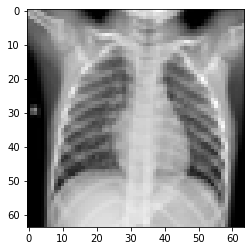

In [7]:
import pickle
import torch
#dataset = datasets.MNIST(root='PATH', train=False, download=True, transform=transforms.ToTensor())
# dataset = datasets.MNIST(root='PATH', train=True, download=True, transform=transforms.ToTensor())
# with open("/data/benchmarking-gnns/data/superpixels/test.pt", 'rb') as f:
#     dataset = pickle.load(f)
# dataset = pickle.load("/data/benchmarking-gnns/data/superpixels/covid19.pkl")
data, label = torch.load("/data/benchmarking-gnns/data/superpixels/train.pt")
if len(data)!=len(label):
    print("Wrong!")
dataset = []
for i in range(len(data)):
    dataset.append((data[i], label[i]))
x, _ = dataset[2] # x is now a torch.Tensor
plt.imshow(x.numpy(), cmap='gray')

### 利用networkx画dgl图示意图

Label:  2


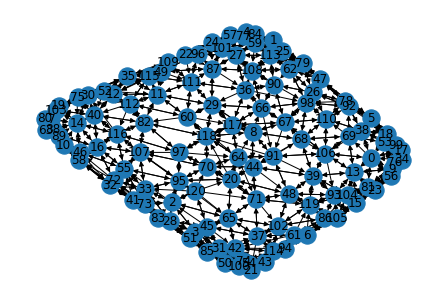

In [9]:
sample = np.random.choice(len(data_no_feat_knn))
g_sample = data_no_feat_knn[sample][0]
print("Label: ", data_no_feat_knn[sample][1])
nx.draw(g_sample.to_networkx(), with_labels=True)
plt.show()

### 超像素图可视化

In [25]:
from scipy.spatial.distance import pdist, squareform
from pylab import rcParams

def plot_superpixels_graph(plt, sp_data, adj_matrix, label, feat_coord, with_edges):
    Y = squareform(pdist(sp_data[1], 'euclidean'))
    x_coord = sp_data[1] #np.flip(dataset.train.sp_data[_][1], 1)
    intensities = sp_data[0].reshape(-1)

    G = nx.from_numpy_matrix(Y)
    pos = dict(zip(range(len(x_coord)), x_coord.tolist()))
    rotated_pos = {node: (y,-x) for (node, (x,y)) in pos.items()} # rotate the coords by 90 degree
    
    edge_list = []
    for src, dsts in enumerate(compute_edges_list(adj_matrix)[0]):
        for dst in dsts:
            edge_list.append((src, dst))

    nx.draw_networkx_nodes(G, rotated_pos, node_color=intensities, cmap=matplotlib.cm.Reds, node_size=60) #len(intensities))
    if with_edges:
        nx.draw_networkx_edges(G, rotated_pos, edge_list, alpha=0.3)
    title = "Label: " + str(label)
    if feat_coord:
        title += " | k-neighbors: Use both coordinate and feature-vector"
    else:
        title += " | k-neighbors: Only use coordinate"
    if not with_edges:
        title = "Label: " + str(label) + " | No edge, only super-pixels"
    
    plt.title.set_text(title)
    
def show_image(plt, idx, alpha):
    x, label = dataset[idx] # x is now a torch.Tensor
    img = x.numpy() #原来后面还有个[0]
    
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title.set_text("Label: " + str(label) + " | Original Image")

### 取样例进行可视化

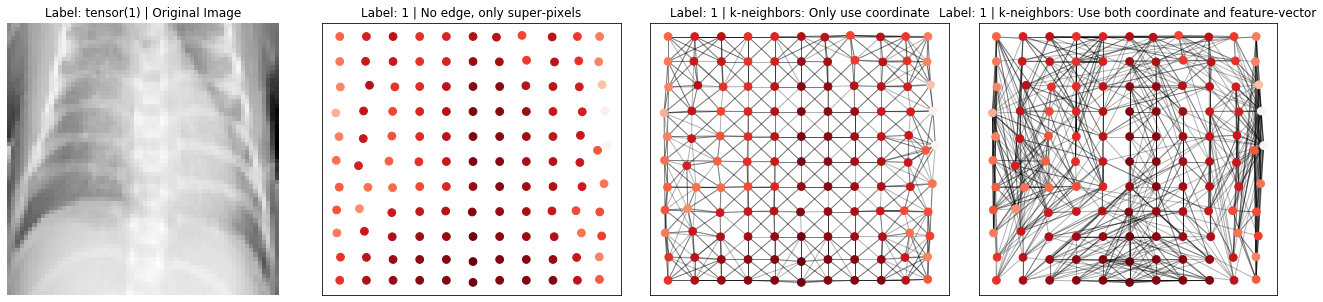

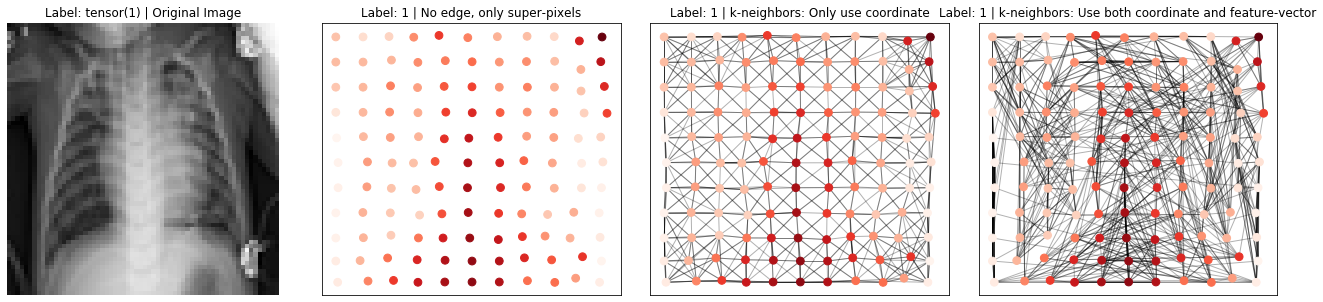

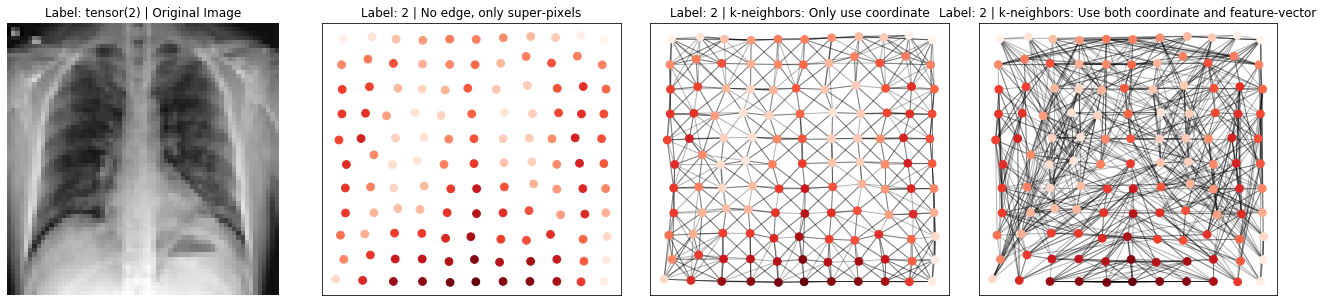

In [28]:
num_samples_plot = 3
for f_idx, idx in enumerate(np.random.choice(int(len(data_no_feat_knn)/2), num_samples_plot, replace=False)):
    f = plt.figure(f_idx, figsize=(23, 5))
    plt1 = f.add_subplot(141)
    show_image(plt1, idx, alpha=0.5)

    plt2 = f.add_subplot(142)  
    plot_superpixels_graph(plt2, data_no_feat_knn.sp_data[idx],
                           data_no_feat_knn.Adj_matrices[idx],
                           data_no_feat_knn[idx][1],
                           data_no_feat_knn.use_feat_for_graph,
                           with_edges=False)

    plt3 = f.add_subplot(143)
    plot_superpixels_graph(plt3, data_no_feat_knn.sp_data[idx],
                           data_no_feat_knn.Adj_matrices[idx],
                           data_no_feat_knn[idx][1],
                           data_no_feat_knn.use_feat_for_graph,
                           with_edges=True)

    plt4 = f.add_subplot(144)
    plot_superpixels_graph(plt4, data_with_feat_knn.sp_data[idx],
                           data_with_feat_knn.Adj_matrices[idx],
                           data_with_feat_knn[idx][1],
                           data_with_feat_knn.use_feat_for_graph,
                           with_edges=True)

    plt.subplots_adjust(hspace=0.1, wspace=0.1)
    f.savefig('visualization/covid19_superpix_'+str(idx)+'.jpg')
    plt.show()